In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from utils.embeddings import sample_circle_features

bias = torch.tensor([0.5, 0.5])

torch.manual_seed(0)

num_features = 100
features = sample_circle_features(num_features, bias, random=False)

import plotly.graph_objects as go
import numpy as np

# Create scatter plot

hover_text = [f"Feature {i}: {feature}" for i, feature in enumerate(features)]
scatter = go.Scatter(
    x=features[:, 0],
    y=features[:, 1],
    mode='markers',
    marker=dict(color='blue'),
    hovertext=hover_text,
    hovertemplate='Feature: %{hovertext}<br>Latent: %{x:.2f}, %{y:.2f}<extra></extra>',
)

# Create circle
theta = np.linspace(0, 2*np.pi, 100)
x = bias[0] + np.cos(theta)
y = bias[1] + np.sin(theta)
circle = go.Scatter(
    x=x,
    y=y,
    mode='lines',
    line=dict(color='red', width=0.5),
    hoverinfo='none'
)

# Create layout
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(range=[bias[0]-1.2, bias[0]+1.2]),
    yaxis=dict(range=[bias[1]-1.2, bias[1]+1.2]),
    xaxis_title="X",
    yaxis_title="Y",
)

# Create figure and add traces
fig = go.Figure(data=[scatter, circle], layout=layout)

# Show the plot
fig.show()


In [3]:
from sae.multi_dim_sae import MultiDimSAE
from sae.sae_config import SAEConfig, MultiDimSAEConfig

config = SAEConfig(
    input_dim=2,
    latent_dim=0,
    multi_dim_config=MultiDimSAEConfig(num_multi_dim_features=2),
)

model = MultiDimSAE(config)

/Users/cybershiptrooper/miniconda3/envs/interp/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning:

Initializing zero-element tensors is a no-op



In [4]:
model.train_model(features, num_epochs=1000)

model.plot_losses()

100%|██████████| 1000/1000 [00:00<00:00, 1070.16it/s]


In [5]:
latents = model.encode(features)[1].detach().numpy()

import plotly.graph_objects as go
import numpy as np

# Create scatter plot
# add the corresponding feature to the hover text
hover_text = [f"Feature {i}: {feature}" for i, feature in enumerate(features)]
scatter = go.Scatter(
    x=latents[:, 0],
    y=latents[:, 1],
    mode='markers',
    marker=dict(color='blue'),
    hovertext=hover_text,
    hovertemplate='Feature: %{hovertext}<br>Latent: %{x:.2f}, %{y:.2f}<extra></extra>',
)

# Create circle
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
circle = go.Scatter(
    x=x,
    y=y,
    mode='lines',
    line=dict(color='red'),
    showlegend=False
)

# Create layout
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(range=[-1.2, 1.2], scaleanchor="y", scaleratio=1),
    yaxis=dict(range=[-1.2, 1.2]),
    showlegend=False
)

# Create figure and add traces
fig = go.Figure(data=[scatter, circle], layout=layout)

# Show plot
fig.show()



In [6]:
from utils.plotter import plot_cosine_similarity
import numpy as np

latents_normalized = latents / np.linalg.norm(latents, axis=1, keepdims=True)
features_normalized = (features - bias) / np.linalg.norm(features - bias, axis=1, keepdims=True)
cosine_similarity = np.einsum("ij,kj->ik", latents_normalized, features_normalized)

plot_cosine_similarity(cosine_similarity, "Latents", "Features")


In [7]:
dec = model.W_dec_multi_dim.detach().numpy()
d_bias = model.b_dec.detach().numpy()
enc = model.W_enc_multi_dim.detach().numpy()

import plotly.graph_objects as go
import numpy as np

# Create circle
theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
circle = go.Scatter(x=x, y=y, mode='lines', line=dict(color='red', width=0.5), showlegend=False, hoverinfo='none')

# Create axes
x_axis = go.Scatter(x=[-2, 2], y=[0, 0], mode='lines', line=dict(color='black', width=0.5), showlegend=False)
y_axis = go.Scatter(x=[0, 0], y=[-2, 2], mode='lines', line=dict(color='black', width=0.5), showlegend=False)

# Create decoder vectors (blue) and encoder vectors (red)
dec_vec1 = go.Scatter(x=[0, dec[0, 0] + d_bias[0]], y=[0, dec[0, 1] + d_bias[1]], mode='lines', line=dict(color='blue'), name='Decoder 1')
dec_vec2 = go.Scatter(x=[0, dec[1, 0] + d_bias[0]], y=[0, dec[1, 1] + d_bias[1]], mode='lines', line=dict(color='blue'), name='Decoder 2')
enc_vec1 = go.Scatter(x=[0, enc[0, 0]], y=[0, enc[0, 1]], mode='lines', line=dict(color='red'), name='Encoder 1')
enc_vec2 = go.Scatter(x=[0, enc[1, 0]], y=[0, enc[1, 1]], mode='lines', line=dict(color='red'), name='Encoder 2')


# Create layout
layout = go.Layout(
    width=500,
    height=500,
    xaxis=dict(range=[-2, 2], scaleanchor="y", scaleratio=1),
    yaxis=dict(range=[-2, 2]),
    showlegend=False
)

# Create figure and add traces
fig = go.Figure(data=[circle, x_axis, y_axis, dec_vec1, dec_vec2, enc_vec1, enc_vec2], layout=layout)

# Show plot
fig.show()


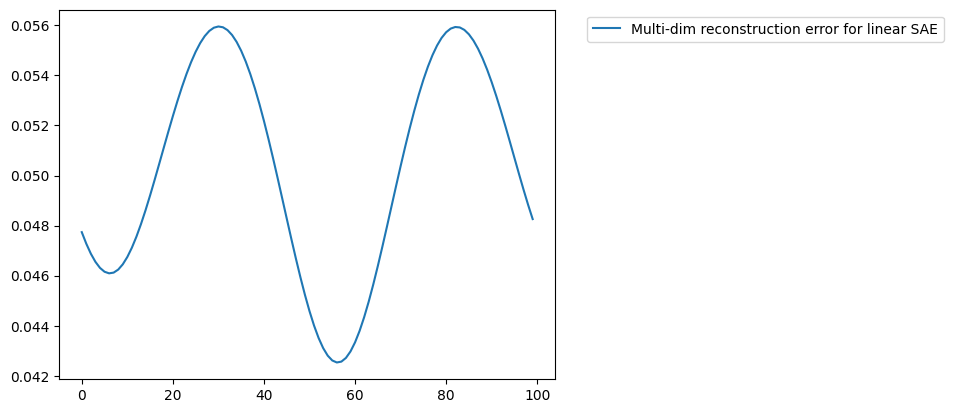

In [8]:
from utils.eval import compute_similarities
linear_similarities, multi_similarities = compute_similarities(model, features, features, use_linear_SAE=False)


# plt.plot(linear_similarities, label="Linear reconstruction error for linear SAE")
plt.plot(multi_similarities, label="Multi-dim reconstruction error for linear SAE")
# legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()